python 陷阱与缺陷
#### 1

UnboundLocalError

In [2]:
a = 1
def func():
    a += 1
    print(a)

In [3]:
func()

UnboundLocalError: local variable 'a' referenced before assignment

In [4]:
a = 1
def test():
    a = 1
    print(a)
test()

1


在于python没有变量的声明 , 所以它通过一个简单的规则找出变量的范围 ：如果有一个函数内部的变量赋值 ，该变量被认为是本地的，所以如果有修改变量的值就会变成局部变量。
另外一个例子：

In [5]:
import random
def func(ok):
    if ok:
        a = random.random()
    else:
        import random #  become local import random
        a = random.randint(1,10)
    return a 
func(True)

UnboundLocalError: local variable 'random' referenced before assignment

解决办法之一，就是在程序开始声明 global a

In [7]:
a = 1
def func():
    global a
    a += 1
    print(a)
func()

2


### 2  


以mutable对象作为默认参数.  默认参数确实是个好东西，可以让函数调用者忽略一些细节（比如GUI编程，Tkinter，QT），对于lambda表达式也非常有用。但是如果使用了可变对象作为默认参数，那么事情就不那么愉快了。

In [9]:
def func(lst = []):
    lst.append(1)
    return lst
print(func())
print(func())

[1]
[1, 1]


究其原因，python中一切都是对象，函数也不列外，默认参数只是函数的一个属性。而默认参数在函数定义的时候已经求值了.下一个例子

In [16]:
import time
def report(when = time.time()):
    return when
print(report())

1571340602.3187706


In [17]:
print(report())

1571340602.3187706


python docoment 给出了标准的解决办法：A way around this is to use None as the default, and explicitly test for it in the body of the function

In [18]:
import time
def report(when = None):
    if when is None:
        when = time.time()
    return when
print(report())

1571340608.5420647


In [19]:
print(report())

1571340609.0638006


###2  x += y vs x = x + y   前者x指向一个新的对象，后者x在原来的对象是修改，当然，那种效果是正确的取决于应用场景。至少，得知道，二者有时候并不一样

In [23]:
x = [1]; print(id(x)); x = x + [2]; print (id(x))

2005092503240
2005092502280


In [24]:
x = [1]; print(id(x)); x += [2]; print (id(x))

2005092501448
2005092501448


### 3 
神奇的小括号–() python中，小括号还能表示元组（tuple）这一数据类型, 元组是immutable的序列

In [27]:
print(type(())); a = (1); print(type(a)); a =(1,); print(type(a))

<class 'tuple'>
<class 'int'>
<class 'tuple'>


### 4 
生成一个元素是列表的列表(生成一个元素是可变对象的序列)

In [30]:
a = [[]]*10
print(a)

[[], [], [], [], [], [], [], [], [], []]


In [31]:
a[0].append(10)
print(a[0])
print(a[1])
print(a)

[10]
[10]
[[10], [10], [10], [10], [10], [10], [10], [10], [10], [10]]


python中list是可变对象，上述的写法大家都指向的同一个可变对象，正确的姿势

In [32]:
a = [[] for _ in range(10)]
a[0].append(10)
print(a)

[[10], [], [], [], [], [], [], [], [], []]


### 5 
在访问列表的时候，修改列表

列表（list）在python中使用非常广泛，当然经常会在访问列表的时候增加或者删除一些元素。比如，下面这个函数，试图删掉列表中为3的倍数的元素

In [34]:
def modify_lst(lst):
    for idx, elem in enumerate(lst):
        if elem % 3 == 0:
            del lst[idx]
lst = [1,2,3,4,5,6]
modify_lst(lst)
print(lst)
lst = [1,2,3,6,5,4]
modify_lst(lst)
print(lst)

[1, 2, 4, 5]
[1, 2, 6, 5, 4]


上面的例子中，6这个元素就没有被删除。如果在modify_lst函数中print idx， item就可以发现端倪：lst在变短，但idx是递增的，所以在上面出错的例子中，当3被删除之后，6变成了lst的第2个元素（从0开始）。在C++中，如果遍历容器的时候用迭代器删除元素，也会有同样的问题。如果逻辑比较简单，使用list comprehension是不错的注意([for i in range(k) if ...])

# 6
闭包与lambda

In [39]:
def create_multipliers():
    return [lambda x: i*x for i in range(5)]
for multiplier in create_multipliers():
    print(multiplier(2))

8
8
8
8
8


create_multipliers函数的返回值时一个列表，列表的每一个元素都是一个函数 －－ 将输入参数x乘以一个倍数i的函数。预期的结果时0，2，4，6，8. 但结果是5个8，意外不意外。

由于出现这个陷阱的时候经常使用了lambda，所以可能会认为是lambda的问题，但lambda表示不愿意背这个锅。问题的本质在与python中的属性查找规则，LEGB（local，enclousing，global，bulitin），在上面的例子中，i就是在闭包作用域（enclousing），而Python的闭包是 迟绑定 ， 这意味着闭包中用到的变量的值，是在内部函数被调用时查询得到的。

解决办法也很简单，那就是变闭包作用域为局部作用域。



In [41]:
def create_multipliers():
    return [lambda x, i = i: i*x for i in range(5)]
for multiplier in create_multipliers():
    print(multiplier(2))

0
2
4
6
8


# 7

定义__del__

大多数计算机专业的同学可能都是先学的C、C++，构造、析构函数的概念应该都非常熟。于是，当切换到python的时候，自然也想知道有没有相应的函数。比如，在C++中非常有名的RAII，即通过构造、析构来管理资源（如内存、文件描述符）的声明周期。那在python中要达到同样的效果怎么做呢，即需要找到一个对象在销毁的时候一定会调用的函数，于是发现了__init__, __del__函数，可能简单写了两个例子发现确实也能工作。但事实上可能掉进了一个陷阱，在python documnet是有描述的：　　


Circular references which are garbage are detected when the option cycle detector is enabled (it’s on by default), but can only be cleaned up if there are no Python-level __del__() methods involved.


简单来说，如果在循环引用中的对象定义了__del__,那么python gc不能进行回收，因此，存在内存泄漏的风险



# 8 

不同的姿势import同一个module

示例在stackoverflow的例子上稍作修改，假设现在有一个package叫mypackage，里面包含三个python文件：mymodule.py, main.py, __init__.py。mymodule.py代码如下

In [ ]:
l = []
class A(object):
    pass

# main.py
def add(x):
    from mypackage import mymodule 
    mymodule.l.append(x) 
    print('updated list','mymodule.l', id(mymodule))
          
def get():
    import mymodule    
    print('module in get', id(mymodule))
    return mymodule.l

if __name__ == '__main__':
    import sys 
    sys.path.append('../') 
    add(1) 
    ret = get() 
    print("lets check", ret)

运行python main.py，结果如下：

updated list [1]  4406700752

module in get 4406700920

lets check []

从运行结果可以看到，在add 和 get函数中import的mymodule不是同一个module，ID不同。当然，在python2.7.10中，需要main.py的第13行才能出现这样的效果。你可能会问，谁会写出第13行这样的代码呢？事实上，在很多项目中，为了import的时候方便，会往sys.path加入一堆路径。那么在项目中，大家同意一种import方式就非常有必要了



# 9 
python升级

python3.x并不向后兼容，所以如果从2.x升级到3.x的时候得小心了，下面列举两点：

在python2.7中，range的返回值是一个列表；而在python3.x中，返回的是一个range对象。

map()、filter()、 dict.items()在python2.7返回列表，而在3.x中返回迭代器。当然迭代器大多数都是比较好的选择，更加pythonic，但是也有缺点，就是只能遍历一次。在instagram的分享中，也提到因为这个导致的一个坑爹的bug



# 10 gil

以GIL结尾，因为gil是Python中大家公认的缺陷！

从其他语言过来的同学可能看到python用threading模块，拿过来就用，结果发现效果不对啊，然后就会喷，什么鬼。

# 11

setattr getattr getattribute

getattr与setattr相差很大，在《python属性查找（attribute look up）》一文中有详细介绍。简单说来，setattr与getattribute是对应的，都是修改python默认的属性修改、查找机制，而getattr只是默认查找机制无法找到属性的时候才会调用，setattr应该叫setattribute__才恰当


# 12
整数比较

在 Python 中一切都是对象，整数也是对象，在比较两个整数时有两个运算符==和is，它们的区别是：

is比较的是两个整数对象的id值是否相等，也就是比较两个引用是否代表了内存中同一个地址。
==比较的是两个整数对象的内容是否相等，使用==时其实是调用了对象的__eq__()方法。


对于整数对象，Python把一些频繁使用的整数对象缓存起来，保存到一个叫small_ints的链表中，在Python的整个生命周期内，任何需要引用这些整数对象的地方，都不再重新创建新的对象，而是直接引用缓存中的对象。Python把频繁使用的整数对象的值定在[-5, 256]这个区间，如果需要这个范围的整数，就直接从small_ints中获取引用而不是临时创建新的对象。因为大于256或小于-5的整数不在该范围之内，所以就算两个整数的值是一样，但它们是不同的对象。

In [45]:
import dis
a = 257


def main():
	b = 257  # 第6行
	c = 257  # 第7行
	print(b is c)  # True
	print(a is b)  # False
	print(a is c)  # False


if __name__ == "__main__":
	main()

True
False
False


程序的执行结果已经用注释写在代码上了。够坑吧！看上去a、b和c的值都是一样的，但是is运算的结果却不一样。为什么会出现这样的结果，首先我们来说说Python程序中的代码块。所谓代码块是程序的一个最小的基本执行单位，一个模块文件、一个函数体、一个类、交互式命令中的单行代码都叫做一个代码块。上面的代码由两个代码块构成，a = 257是一个代码块，main函数是另外一个代码块。Python内部为了进一步提高性能，凡是在一个代码块中创建的整数对象，如果值不在small_ints缓存范围之内，但在同一个代码块中已经存在一个值与其相同的整数对象了，那么就直接引用该对象，否则创建一个新的对象出来，这条规则对不在small_ints范围的负数并不适用，对负数值浮点数也不适用，但对非负浮点数和字符串都是适用的，这一点读者可以自行证明。所以 b is c返回了True，而a和b不在同一个代码块中，虽然值都是257，但却是两个不同的对象，is运算的结果自然是False了。 为了验证刚刚的结论，我们可以借用dis模块（听名字就知道是进行反汇编的模块）从字节码的角度来看看这段代码。如果不理解什么是字节码，可以先看看《谈谈 Python 程序的运行原理》这篇文章。可以先用import dis导入dis模块并按照如下所示的方式修改代码

In [ ]:
if __name__ == "__main__":
    main()
    dis.dis(main)

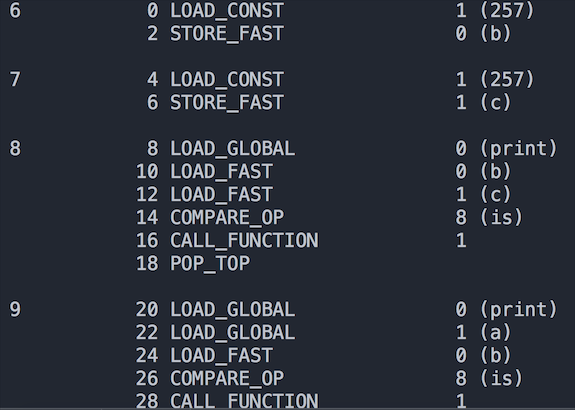
代码的执行结果如下图所示。可以看出代码第6行和第7行，也就是main函数中的257是从同一个位置加载的，因此是同一个对象；而代码第9行的a明显是从不同的地方加载的，因此引用的是不同的对象。

# 13 
访问修饰符


ython的类提供了两种访问控制权限，一种是公开，一种是私有（在属性或方法前加上双下划线）。而用惯了Java或C#这类编程语言的人都知道，类中的属性（数据抽象）通常都是私有的，其目的是为了将数据保护起来；而类中的方法（行为抽象）通常都是公开的，因为方法是对象向外界提供的服务。但是Python并没有从语法层面确保私有成员的私密性，因为它只是对类中所谓的私有成员进行了命名的变换，如果知道命名的规则照样可以直接访问私有成员，请看下面的代码

In [46]:
class Student(object):

    def __init__(self, name, age):
        self.__name = name
        self.__age = age

    def __str__(self):
        return self.__name + ': ' + str(self.__age)


def main():
    stu = Student('骆昊', 38)
    # 'Student' object has no attribute '__name'
    # print(stu.__name)
    # 用下面的方式照样可以访问类中的私有成员
    print(stu._Student__name)
    print(stu._Student__age)


if __name__ == '__main__':
    main()

骆昊
38


Python为什么要做出这样的设定呢？用一句广为流传的格言来解释这个问题：“We are all consenting adults here”（我们都是成年人）。这句话表达了很多Python程序员的一个共同观点，那就是开放比封闭要好，我们应该自己对自己的行为负责而不是从语言层面来限制对数据或方法的访问。

所以在Python中我们实在没有必要将类中的属性或方法用双下划线开头的命名处理成私有的成员，因为这并没有任何实际的意义。如果想对属性或方法进行保护，我们建议用单下划线开头的受保护成员，虽然它也不能真正保护这些属性或方法，但是它相当于给调用者一个暗示，让调用者知道这是不应该直接访问的属性或方法，而且这样做并不影响子类去继承这些东西。

需要提醒大家注意的是，Python类中的那些魔法方法，如__str__、__repr__等，这些方法并不是私有成员哦，虽然它们以双下划线开头，但是他们也是以双下划线结尾的，这种命名并不是私有成员的命名，这一点对初学者来说真的很坑

# 14
一般的Python教程会告诉你，当函数执行到第一个return的时候会退出，剩下的语句不再执行。然而如果是这样的话上面的代码中我们的somefunc()应该返回的是'from_try'，但结果却不是。这个现象的原因是finally后面的语句永远会执行，而函数的返回值由最后一个return语句决定，所以函数的返回值是finally语句中的返回值。


In [4]:
def some_func():
     try:
         return 'from_try'
     finally:
         return 'from_finally'     

some_func()

'from_finally'

# 15

Python的for循环的机制，每次在循环体之前，下一个需要的值先会产生好然后赋值给循环变量，这里的i。也就是说，虽然循环体中有一个i = 10，但下次循环前for又会做一个i=2或者i=3的操作，把i=10覆盖了。

In [6]:
for i in range(4):
    print(i)
    i = 10

0
1
2
3
